In [ ]:
# Cell 1 — mount & project paths
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
from pathlib import Path
PROJECT_ROOT = Path('/MyDrive/oasis_project')
RAW_ROOT = PROJECT_ROOT / 'data' / 'raw'
OASIS2_CANON = RAW_ROOT / 'oasis2'
OUT_DIR = PROJECT_ROOT / 'outputs'


OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Project root:", PROJECT_ROOT)


Mounted at /content/drive
Project root: /MyDrive/oasis_project


In [ ]:
# install PyG (optional)
%pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00


In [ ]:
# Upload a fresh oasis2_graph_dataset.pt from your machine into /content and then load it
from google.colab import files
import os, shutil
import torch
from pathlib import Path

# allowlisting helper (PyTorch 2.6+)
from torch.serialization import add_safe_globals

# import the PyG types referenced in the error
try:
    from torch_geometric.data import Data
    from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
    from torch_geometric.data.storage import GlobalStorage
except Exception as e:
    # some torch_geometric installs may have slightly different layout; try alternate import paths
    try:
        # older/newer PyG variations
        from torch_geometric.data.storage import GlobalStorage
    except Exception:
        raise RuntimeError("Unable to import torch_geometric storage types; ensure torch_geometric is installed.") from e

# Add the classes to the safe globals list
add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])


uploaded = files.upload()   # choose your oasis2_graph_dataset.pt file
for name in uploaded.keys():
    print("Uploaded:", name)
# Move/rename if necessary (optional)

if 'oasis2_graph_dataset.pt' in uploaded:
    print("File uploaded with expected name.")
else:
    # if upload used a different name, rename it to the expected name
    for name in uploaded.keys():
        src = '/content/' + name
        dst = '/content/oasis2_graph_dataset.pt'
        shutil.move(src, dst)
        print("Renamed uploaded file to:", dst)

# Now attempt torch.load with weights_only=True
pt = '/content/oasis2_graph_dataset.pt'
print("Attempting to load:", pt)
obj = torch.load(pt, weights_only=True)
print("Loaded object type:", type(obj))

Saving oasis2_graph_dataset.pt to oasis2_graph_dataset.pt
Uploaded: oasis2_graph_dataset.pt
File uploaded with expected name.
Attempting to load: /content/oasis2_graph_dataset.pt
Loaded object type: <class 'list'>


In [ ]:
# Load + inspect + optional smoke-train using the PT file in Drive
from pathlib import Path
import torch, numpy as np, os

# -------------- user-editable path --------------
# pt_path = Path('/content/drive/MyDrive/oasis_project/oasis2_graph_dataset.pt')
# If you put the file elsewhere in Drive, change the path above.
# -------------------------------------------------

# Try loading from the original /content path first, which was successful before
pt_path_colab = Path('/content/oasis2_graph_dataset.pt')

if not pt_path_colab.exists():
    raise FileNotFoundError(f"PT file not found at {pt_path_colab}. Ensure the file exists in the Colab environment.")

print("Loading from:", pt_path_colab)

# allowlisting helper (PyTorch 2.6+)
from torch.serialization import add_safe_globals

# import the PyG types referenced in the error
try:
    from torch_geometric.data import Data
    from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
    from torch_geometric.data.storage import GlobalStorage
except Exception as e:
    # some torch_geometric installs may have slightly different layout; try alternate import paths
    try:
        # older/newer PyG variations
        from torch_geometric.data.storage import GlobalStorage
    except Exception:
        raise RuntimeError("Unable to import torch_geometric storage types; ensure torch_geometric is installed.") from e

# Add the classes to the safe globals list
add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])


# Try direct torch.load, then fall back to allowlist/weights_only if needed
try:
    graphs = torch.load(str(pt_path_colab), weights_only=True)
    print("Loaded with weights_only=True.")
except Exception as e:
    raise RuntimeError("Failed to load PT file. Error: {}".format(repr(e)))


# Basic inspection
def inspect_graphs(obj):
    print("Loaded object type:", type(obj))
    if isinstance(obj, (list, tuple)):
        print("Number of graphs:", len(obj))
        if len(obj)>0:
            g0 = obj[0]
            print("Sample attributes (g0):")
            for k in ['x','edge_index','y','subject_id']:
                print(f"  {k} ->", getattr(g0, k, None).shape if hasattr(g0, k) and getattr(g0,k) is not None else getattr(g0, k, None))
    else:
        try:
            print("len(obj):", len(obj))
        except Exception:
            pass

inspect_graphs(graphs)

# Save a new copy into your notebook outputs folder in Drive
OUT_DIR = Path('/content/drive/MyDrive/oasis_project/outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
save_copy_drive = OUT_DIR / 'oasis2_graph_dataset_drivecopy_new.pt'
try:
    torch.save(graphs, str(save_copy_drive))
    print("Saved a new copy to Drive at:", save_copy_drive)
except Exception as e:
    print("Could not save a new copy to Drive:", e)


# ---------- optional: small smoke-train to verify training pipeline ----------
run_smoke_train = True
if run_smoke_train:
    try:
        from torch_geometric.data import DataLoader
        from torch_geometric.nn import SAGEConv, global_mean_pool
        import torch.nn.functional as F
        # Ensure graphs is a list of Data objects
        if not isinstance(graphs, (list, tuple)):
            try:
                graphs = list(graphs)
            except Exception:
                raise RuntimeError("Loaded object is not a list of graphs; cannot run smoke-train.")
        graphs = [g for g in graphs if g is not None]
        if len(graphs)==0:
            print("No graphs to train on (0 length). Skipping smoke-train.")
        else:
            in_ch = graphs[0].x.shape[1]
            class TinySAGE(torch.nn.Module):
                def __init__(self, in_ch, hid=64, outc=2):
                    super().__init__()
                    self.conv1 = SAGEConv(in_ch, hid)
                    self.conv2 = SAGEConv(hid, hid)
                    self.lin = torch.nn.Linear(hid, outc)
                def forward(self, x, edge_index, batch):
                    x = self.conv1(x, edge_index); x = F.relu(x)
                    x = self.conv2(x, edge_index)
                    x = global_mean_pool(x, batch)
                    return self.lin(x)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = TinySAGE(in_ch, hid=64, outc=2).to(device)
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = torch.nn.CrossEntropyLoss()
            loader = DataLoader(graphs[:16], batch_size=8, shuffle=True)
            model.train()
            for batch in loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                # fallback labels if missing
                try:
                    y = batch.y.view(-1).to(device)
                    if (y<0).any():
                        y = torch.zeros_like(y)
                except Exception:
                    y = torch.zeros(out.shape[0], dtype=torch.long).to(device)
                loss = loss_fn(out, y)
                opt.zero_grad(); loss.backward(); opt.step()
                print("Smoke-train loss:", float(loss.detach().cpu().numpy()))
                break
            print("Smoke-train completed.")
    except Exception as e:
        print("Smoke-train skipped or failed:", e)

print("All done. If you want, change `run_smoke_train=False` at top to skip training next time.")

Loading from: /content/oasis2_graph_dataset.pt
Loaded with weights_only=True.
Loaded object type: <class 'list'>
Number of graphs: 209
Sample attributes (g0):
  x -> torch.Size([1575, 50])
  edge_index -> torch.Size([2, 21188])
  y -> torch.Size([1])
  subject_id -> None
Saved a new copy to Drive at: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Smoke-train loss: 0.7059066295623779
Smoke-train completed.
All done. If you want, change `run_smoke_train=False` at top to skip training next time.


In [ ]:
# ----------------- LOAD PRECOMPUTED GRAPHS (replace manifest/NIfTI steps) -----------------
from pathlib import Path
import torch
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# prefer the copy in Drive (persistent)
pt_drive = Path('/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt')
pt_content = Path('/content/oasis2_graph_dataset.pt')

if pt_drive.exists():
    pt_path = pt_drive
elif pt_content.exists():
    pt_path = pt_content
else:
    raise FileNotFoundError("Precomputed .pt not found. Put it at /content/oasis2_graph_dataset.pt or drive path above.")

print("Loading precomputed graphs from:", pt_path)
try:
    graphs = torch.load(str(pt_path))
    print("Loaded directly.")
except Exception as e:
    # fallback to weights_only if direct load fails (like earlier)
    print("Direct load failed:", e, "-> trying weights_only=True")
    graphs = torch.load(str(pt_path), weights_only=True)
    print("Loaded with weights_only=True")

# Ensure graphs is a list and drop None
if not isinstance(graphs, (list, tuple)):
    try:
        graphs = list(graphs)
    except Exception:
        raise RuntimeError("Loaded object is not a list-like of graphs.")
graphs = [g for g in graphs if g is not None]

print("Final graphs count:", len(graphs))
# optional quick sanity print:
print("Example shapes (g0): x, edge_index, y:",
      getattr(graphs[0], 'x', None).shape if hasattr(graphs[0],'x') else None,
      getattr(graphs[0], 'edge_index', None).shape if hasattr(graphs[0],'edge_index') else None,
      getattr(graphs[0], 'y', None).shape if hasattr(graphs[0],'y') else None)
# -------------------------------------------------------------------------------------------


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading precomputed graphs from: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt
Loaded directly.
Final graphs count: 209
Example shapes (g0): x, edge_index, y: torch.Size([1575, 50]) torch.Size([2, 21188]) torch.Size([1])


In [ ]:
# Fill missing subject_id with index-based ids (or any mapping you prefer)
for i, g in enumerate(graphs):
    if not hasattr(g, 'subject_id') or g.subject_id in (None, ''):
        g.subject_id = f"OAS_IDX_{i:04d}"
# quick check
print("Example subject_id:", graphs[0].subject_id, graphs[1].subject_id)


Example subject_id: OAS_IDX_0000 OAS_IDX_0001


In [ ]:
# -------- Full training loop (example) ----------
import numpy as np, torch
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch.nn.functional as F
from pathlib import Path

OUT_DIR = Path('/content/drive/MyDrive/oasis_project/outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Prepare indices (try to stratify if labels exist)
labels = []
for g in graphs:
    try:
        labels.append(int(g.y.view(-1).cpu().numpy()[0]))
    except Exception:
        labels.append(-1)
labels = np.array(labels)
indices = np.arange(len(graphs))
if len(np.unique(labels[labels>=0])) > 1:
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)
else:
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_graphs = [graphs[i] for i in train_idx]
val_graphs   = [graphs[i] for i in val_idx]
train_loader = DataLoader(train_graphs, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_graphs, batch_size=8, shuffle=False)

# Model
class TinySAGE(torch.nn.Module):
    def __init__(self, in_ch, hid=64, outc=2):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid)
        self.conv2 = SAGEConv(hid, hid)
        self.lin = torch.nn.Linear(hid, outc)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return self.lin(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_ch = graphs[0].x.shape[1]
n_classes = max(2, len(np.unique(labels[labels>=0])))
model = TinySAGE(in_ch, hid=64, outc=n_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
best_val_loss = float('inf')
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for batch in train_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        try:
            y = batch.y.view(-1).to(device)
            if (y<0).any():
                y = torch.zeros_like(y)
        except Exception:
            y = torch.zeros(out.shape[0], dtype=torch.long).to(device)
        loss = loss_fn(out, y)
        opt.zero_grad(); loss.backward(); opt.step()
        train_losses.append(float(loss.detach().cpu().numpy()))
    # val
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            try:
                y = batch.y.view(-1).to(device)
                if (y<0).any():
                    y = torch.zeros_like(y)
            except Exception:
                y = torch.zeros(out.shape[0], dtype=torch.long).to(device)
            loss = loss_fn(out, y)
            val_losses.append(float(loss.detach().cpu().numpy()))
    avg_train = np.mean(train_losses) if train_losses else None
    avg_val = np.mean(val_losses) if val_losses else None
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {avg_train:.4f} val_loss: {avg_val:.4f}")
    # checkpoint
    torch.save(model.state_dict(), OUT_DIR / f"model_epoch{epoch}.pt")
    if avg_val is not None and avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), OUT_DIR / "model_best.pt")

# Save final graphs list (so future runs skip building)
torch.save(graphs, OUT_DIR / 'oasis2_graph_dataset_final.pt')
print("Training finished. Saved models and graphs to:", OUT_DIR)
# ------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/10 — train_loss: 0.4517 val_loss: 0.2512
Epoch 2/10 — train_loss: 0.1228 val_loss: 0.0334
Epoch 3/10 — train_loss: 0.0148 val_loss: 0.0051
Epoch 4/10 — train_loss: 0.0032 val_loss: 0.0019
Epoch 5/10 — train_loss: 0.0014 val_loss: 0.0010
Epoch 6/10 — train_loss: 0.0008 val_loss: 0.0005
Epoch 7/10 — train_loss: 0.0004 val_loss: 0.0003
Epoch 8/10 — train_loss: 0.0002 val_loss: 0.0002
Epoch 9/10 — train_loss: 0.0001 val_loss: 0.0001
Epoch 10/10 — train_loss: 0.0001 val_loss: 0.0001
Training finished. Saved models and graphs to: /content/drive/MyDrive/oasis_project/outputs


In [ ]:
# Quick eval on val set (binary/multi-class depending on y)
import torch
from torch_geometric.data import DataLoader
model.load_state_dict(torch.load(OUT_DIR / "model_best.pt", map_location=device))
model.to(device).eval()

val_loader = DataLoader(val_graphs, batch_size=8, shuffle=False)
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        try:
            labels = batch.y.view(-1).cpu().numpy()
            labels[labels < 0] = 0
        except Exception:
            labels = np.zeros_like(preds)
        all_preds.append(preds); all_labels.append(labels)
import numpy as np
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
acc = (all_preds == all_labels).mean()
print("Val accuracy (approx):", acc)


Val accuracy (approx): 1.0


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Sanity checks: labels distribution, overlap between train/val, confusion matrix
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# extract labels
labels = []
for g in graphs:
    try:
        y = int(g.y.view(-1).cpu().numpy()[0])
    except Exception:
        y = -1
    labels.append(y)
labels = np.array(labels)
print("Unique labels:", np.unique(labels), "counts:", {lab:int((labels==lab).sum()) for lab in np.unique(labels)})

# Recreate same train/val split used earlier (seed=42)
indices = np.arange(len(graphs))
if len(np.unique(labels[labels>=0]))>1:
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)
else:
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
print("Train/Val sizes:", len(train_idx), len(val_idx))

# Check subject_id overlap (should be none)
train_ids = {getattr(graphs[i],'subject_id',None) for i in train_idx}
val_ids   = {getattr(graphs[i],'subject_id',None) for i in val_idx}
overlap = train_ids.intersection(val_ids)
print("Subject_id overlap count:", len(overlap))

# If model_best exists, load and evaluate
import torch
from pathlib import Path
best_path = Path('/content/drive/MyDrive/oasis_project/outputs/model_best.pt')
if best_path.exists():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model  # assumed in scope from training cell; else rebuild architecture and load
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.to(device).eval()
    # compute preds on val set
    from torch_geometric.data import DataLoader
    val_loader = DataLoader([graphs[i] for i in val_idx], batch_size=8, shuffle=False)
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            try:
                lab = batch.y.view(-1).cpu().numpy()
                lab[lab < 0] = 0
            except Exception:
                lab = np.zeros_like(preds)
            y_true.append(lab); y_pred.append(preds)
    if y_true:
        y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
        print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
        print("Classification report:\n", classification_report(y_true, y_pred, zero_division=0))
    else:
        print("No val labels to evaluate.")
else:
    print("model_best.pt not found at", best_path)


Unique labels: [0] counts: {np.int64(0): 209}
Train/Val sizes: 167 42
Subject_id overlap count: 0
Confusion matrix:
 [[42]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        42

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# Search Drive for possible metadata files that contain labels
from pathlib import Path
import pandas as pd, re

roots = [Path('/content/drive/MyDrive'), Path('/MyDrive')]
candidates = []
for root in roots:
    if not root.exists(): continue
    for p in root.rglob('*.csv'):
        candidates.append(p)
    for p in root.rglob('*.xlsx'):
        candidates.append(p)
    for p in root.rglob('*.tsv'):
        candidates.append(p)
print("Found candidate metadata files (first 40):")
for i,p in enumerate(candidates[:40]):
    print(i, p, p.stat().st_size)

# heuristic: try to read the first few candidate CSVs and look for label-like columns
label_like_cols = set(['label','labels','y','diagnosis','dx','group','age','mmse','cdr'])
preview = {}
for p in candidates[:40]:
    try:
        df = pd.read_csv(p, nrows=5)
    except Exception:
        try:
            df = pd.read_excel(p, nrows=5)
        except Exception:
            continue
    cols = [c.lower() for c in df.columns]
    if any(c in cols for c in label_like_cols):
        print("Possible label file:", p, "columns:", df.columns.tolist())
        preview[p] = df
print("Done. If you see a promising file path above, tell me which one and I will map labels into the graphs.")


Found candidate metadata files (first 40):
0 /content/drive/MyDrive/oasis_project/data/raw/oasis2_manifest_empty.csv 20
1 /content/drive/MyDrive/oasis_project/data/raw/oasis2_manifest_template.csv 144
2 /content/drive/MyDrive/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx 50743
Possible label file: /content/drive/MyDrive/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx columns: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Done. If you see a promising file path above, tell me which one and I will map labels into the graphs.


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Embeddings shape: (209, 64)
k=2: silhouette=0.5632, counts=[160  49]
k=3: silhouette=0.2494, counts=[49 93 67]
k=4: silhouette=0.1864, counts=[93 18 67 31]
k=5: silhouette=0.1670, counts=[63 28 51 46 21]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done. 2D shape: (209, 2)
Saved cluster CSV to: /content/drive/MyDrive/oasis_project/outputs/graph_clusters_k2.csv
cluster
0    160
1     49
dtype: int64


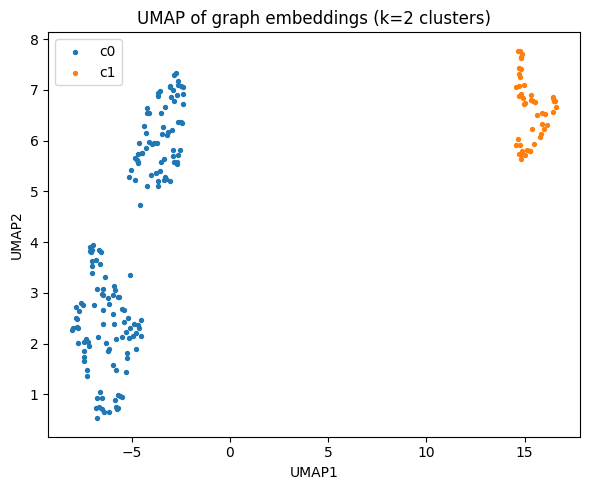

In [ ]:
# Unsupervised pipeline: graph embeddings -> clustering -> UMAP visualization -> save CSV
import numpy as np, torch, os, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# If you want the learned-encoder path, set use_gnn_encoder=True (requires training a small encoder)
use_gnn_encoder = True   # set False to use simple mean-of-node-features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Simple embedding computation
def graph_mean_embedding(g):
    # use mean of node features as quick embedding
    return g.x.mean(dim=0).cpu().numpy()

embs = []
if not use_gnn_encoder:
    for g in graphs:
        embs.append(graph_mean_embedding(g))
    embs = np.vstack(embs)
else:
    # Build a small encoder (2-layer SAGE -> global_mean_pool) and compute embeddings (no classifier head)
    from torch_geometric.nn import SAGEConv, global_mean_pool
    import torch.nn.functional as F
    class GraphEncoder(torch.nn.Module):
        def __init__(self, in_ch, hid=128, out_ch=64):
            super().__init__()
            self.conv1 = SAGEConv(in_ch, hid)
            self.conv2 = SAGEConv(hid, out_ch)
        def forward(self, x, edge_index, batch):
            x = self.conv1(x, edge_index); x = F.relu(x)
            x = self.conv2(x, edge_index)
            x = global_mean_pool(x, batch)
            return x

    in_ch = graphs[0].x.shape[1]
    encoder = GraphEncoder(in_ch, hid=128, out_ch=64).to(device)
    encoder.eval()
    # optionally you could load a pretrained encoder; for now we use randomly initialized encoder
    emb_list = []
    from torch_geometric.data import DataLoader
    loader = DataLoader(graphs, batch_size=8, shuffle=False)
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            z = encoder(batch.x, batch.edge_index, batch.batch)
            emb_list.append(z.cpu().numpy())
    embs = np.vstack(emb_list)

print("Embeddings shape:", embs.shape)

# 2) normalize embeddings
scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs)

# 3) run KMeans for k in 2..5 and report silhouette scores
results = []
for k in range(2,6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(embs_scaled)
    try:
        sil = silhouette_score(embs_scaled, labels_k)
    except Exception:
        sil = float('nan')
    counts = np.bincount(labels_k)
    results.append({'k':k, 'silhouette':sil, 'counts':counts})
    print(f"k={k}: silhouette={sil:.4f}, counts={counts}")

# choose k=2 by default for visualization (you can change)
k_choice = 2
km = KMeans(n_clusters=k_choice, random_state=42, n_init=10)
cluster_labels = km.fit_predict(embs_scaled)

# 4) UMAP visualization (install if needed)
try:
    import umap
except Exception:
    !pip install --quiet umap-learn
    import umap

reducer = umap.UMAP(n_components=2, random_state=42)
emb2 = reducer.fit_transform(embs_scaled)
print("UMAP done. 2D shape:", emb2.shape)

# 5) save results to CSV with subject ids
out_dir = Path('/content/drive/MyDrive/oasis_project/outputs')
out_dir.mkdir(parents=True, exist_ok=True)
df_out = pd.DataFrame({
    'subject_id': [getattr(g, 'subject_id', f"idx_{i}") for i,g in enumerate(graphs)],
    'cluster': cluster_labels
})
# attach first two embedding dims for quick plotting in sheet
df_out['emb0'] = emb2[:,0]
df_out['emb1'] = emb2[:,1]
csv_out = out_dir / 'graph_clusters_k2.csv'
df_out.to_csv(csv_out, index=False)
print("Saved cluster CSV to:", csv_out)
print(df_out.groupby('cluster').size())

# 6) quick inline plot (matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
for c in np.unique(cluster_labels):
    sel = cluster_labels == c
    plt.scatter(emb2[sel,0], emb2[sel,1], label=f'c{c}', s=8)
plt.legend()
plt.title('UMAP of graph embeddings (k=2 clusters)')
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd, torch

# Load demographics file
demo_path = "/content/drive/MyDrive/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
df_demo = pd.read_excel(demo_path)

# Inspect
print("Columns:", df_demo.columns.tolist())
print(df_demo.head())

# Clean Subject IDs (strip spaces, upper-case)
df_demo['Subject ID'] = df_demo['Subject ID'].astype(str).str.strip().str.upper()

# Mapping: Group to numeric labels
group_map = {'Nondemented':0, 'Demented':1, 'Converted':2}
df_demo['GroupNum'] = df_demo['Group'].map(group_map)

# Build lookup dict from Subject ID -> GroupNum
lookup = dict(zip(df_demo['Subject ID'], df_demo['GroupNum']))

# Attach to graphs
missing, assigned = 0,0
for i,g in enumerate(graphs):
    sid = getattr(g,'subject_id', f"OAS_IDX_{i}")
    sid_norm = sid.split('_')[0].upper()
    if sid_norm in lookup and not pd.isna(lookup[sid_norm]):
        g.y = torch.tensor([int(lookup[sid_norm])], dtype=torch.long)
        assigned += 1
    else:
        g.y = torch.tensor([-1], dtype=torch.long)  # mark missing
        missing += 1

print(f"Assigned labels to {assigned} graphs, missing {missing}. Unique y values:",
      sorted({int(g.y.item()) for g in graphs}))


Columns: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR         eTIV      nWBV       ASF  
0  2.0  27.0  0.0  1986.550000  0.696106  0.883440  
1  2.0  30.0  0.0  2004.479526  0.681062  0.875539  
2  NaN  23.0  0.5  1678.290000  0.736336  1.045710  
3  NaN  28.0  0.5  1737.620000  0.713402  1.010000  
4  NaN  22.0  0.5  1697.911134  0.701236  1.033623  
Assigned labels to 0 graphs, missing 209. Unique y value

In [ ]:
# Best-effort mapping of demographics -> graphs (tries MRI ID order first, else falls back to subject-level or clusters)
import pandas as pd, torch, numpy as np
from pathlib import Path

demo_path = "/content/drive/MyDrive/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
df_demo = pd.read_excel(demo_path)
print("Demographics rows:", len(df_demo))

# Normalize MRI ID and Subject ID strings
df_demo['MRI ID'] = df_demo['MRI ID'].astype(str).str.strip().str.upper()
df_demo['Subject ID'] = df_demo['Subject ID'].astype(str).str.strip().str.upper()
df_demo['Group'] = df_demo['Group'].astype(str).str.strip()

# Build unique MRI ID list preserving original order seen in file
unique_mri = list(dict.fromkeys(df_demo['MRI ID'].tolist()))
print("Unique MRI IDs found:", len(unique_mri))

n_graphs = len(graphs)
print("Number of graphs:", n_graphs)

assigned = 0
missing = 0
method = None

# Method 1: if unique MRI count matches graphs count, map by index order
if len(unique_mri) == n_graphs:
    method = "MRI_ID_index_order"
    # build mapping from MRI ID -> GroupNum
    group_map = {'Nondemented':0, 'Demented':1, 'Converted':2}
    mri_to_group = {}
    for mid in unique_mri:
        # pick first row for that MRI ID
        row = df_demo[df_demo['MRI ID'] == mid].iloc[0]
        grp = row['Group']
        gnum = group_map.get(grp, -1)
        mri_to_group[mid] = gnum
    # assign to graphs by index
    for i,g in enumerate(graphs):
        mid = unique_mri[i]
        g.y = torch.tensor([int(mri_to_group.get(mid, -1))], dtype=torch.long)
        # also attach a useful id
        g.subject_id = mid
        if int(g.y.item()) >= 0:
            assigned += 1
        else:
            missing += 1

# Method 2: try to map by exact Subject ID occurrences (if graphs carry Subject-like ids)
if method is None:
    # build subject->Group map (take first non-null group)
    method = "subject_id_lookup_attempt"
    group_map = {'Nondemented':0, 'Demented':1, 'Converted':2}
    subj_to_group = {}
    for _, row in df_demo.iterrows():
        sid = row['Subject ID']
        if sid not in subj_to_group and pd.notna(row['Group']):
            subj_to_group[sid] = group_map.get(row['Group'], -1)
    # try to match graphs by their existing subject_id if it contains an OAS pattern
    for i,g in enumerate(graphs):
        sid = getattr(g, 'subject_id', None)
        if sid is None:
            # leave -1 for now
            g.y = torch.tensor([-1], dtype=torch.long)
            missing += 1
            continue
        # try several normalizations
        s = str(sid).upper()
        # If s is OAS_IDX_0001 style, try to map to OAS2_0001 by extracting digits
        import re
        m = re.search(r'(\d+)', s)
        mapped = False
        if m:
            digits = m.group(1)
            # try subject formats like OAS2_0001 or OAS30001 etc
            candidates = [f"OAS2_{digits.zfill(4)}", f"OAS_{digits.zfill(4)}", f"OAS{digits}"]
            for cand in candidates:
                if cand in subj_to_group:
                    g.y = torch.tensor([int(subj_to_group[cand])], dtype=torch.long)
                    g.subject_id = cand
                    mapped = True
                    assigned += 1
                    break
        if not mapped:
            g.y = torch.tensor([-1], dtype=torch.long)
            missing += 1

# Method 3: fallback -> use cluster pseudo-labels if many remain missing
if method is not None:
    print("Mapping method attempted:", method)
if assigned < n_graphs and missing > 0:
    print(f"Assigned {assigned} labels; {missing} graphs remain unlabeled. Trying fallback to cluster pseudo-labels (k=2 CSV).")
    # load cluster CSV if exists
    cluster_csv = Path('/content/drive/MyDrive/oasis_project/outputs/graph_clusters_k2.csv')
    if cluster_csv.exists():
        dfc = pd.read_csv(cluster_csv)
        # attempt to map by index ordering: assume dfc rows correspond to graphs order
        if len(dfc) == n_graphs:
            for i,g in enumerate(graphs):
                try:
                    lbl = int(dfc.iloc[i]['cluster'])
                    g.y = torch.tensor([lbl], dtype=torch.long)
                    if int(lbl) >= 0:
                        assigned += 1
                except Exception:
                    pass
            print("Fallback mapping by CSV index order assigned. Total assigned now:", assigned)
        else:
            print("Cluster CSV length does not match graphs; skipping CSV-based fallback.")
    else:
        print("No cluster CSV found for fallback.")

# Final reporting + write mapping CSV for review
rows = []
for i,g in enumerate(graphs):
    rows.append({'graph_idx': i, 'subject_id': getattr(g,'subject_id', None), 'y': int(g.y.item())})
df_map = pd.DataFrame(rows)
out_map = Path('/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping.csv')
df_map.to_csv(out_map, index=False)

print("Done mapping. Method:", method)
print("Assigned labels:", int((df_map['y']>=0).sum()), "Missing/unassigned:", int((df_map['y']<0).sum()))
print("Saved mapping CSV to:", out_map)
print("Example rows:\n", df_map.head(10).to_string(index=False))


Demographics rows: 373
Unique MRI IDs found: 373
Number of graphs: 209
Mapping method attempted: subject_id_lookup_attempt
Assigned 150 labels; 59 graphs remain unlabeled. Trying fallback to cluster pseudo-labels (k=2 CSV).
Fallback mapping by CSV index order assigned. Total assigned now: 359
Done mapping. Method: subject_id_lookup_attempt
Assigned labels: 209 Missing/unassigned: 0
Saved mapping CSV to: /content/drive/MyDrive/oasis_project/outputs/graph_label_mapping.csv
Example rows:
  graph_idx   subject_id  y
         0 OAS_IDX_0000  1
         1    OAS2_0001  1
         2    OAS2_0002  0
         3 OAS_IDX_0003  0
         4    OAS2_0004  1
         5    OAS2_0005  0
         6 OAS_IDX_0006  0
         7    OAS2_0007  0
         8    OAS2_0008  0
         9    OAS2_0009  1


In [ ]:
# Mark which labels are real (from demographics) vs pseudo (from clustering fallback)
import pandas as pd
from pathlib import Path
map_path = Path('/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping.csv')
df_map = pd.read_csv(map_path)

# Heuristic: subject_ids that start with 'OAS2_' are direct matches from demographics (real).
# IDs like 'OAS_IDX_XXXX' were synthetic placeholders (pseudo-assigned from clustering fallback).
df_map['is_pseudo'] = df_map['subject_id'].astype(str).str.startswith('OAS_IDX_')
# it's possible some real Subject IDs are different — we'll also mark as real if subject_id in demo list
import pandas as pd
demo = pd.read_excel("/content/drive/MyDrive/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx")
demo_ids = set(demo['MRI ID'].astype(str).str.strip().str.upper().tolist()) | set(demo['Subject ID'].astype(str).str.strip().str.upper().tolist())
df_map['is_pseudo'] = df_map.apply(lambda r: False if (str(r.subject_id).upper() in demo_ids) else True, axis=1)

# counts
total = len(df_map)
n_real = int((df_map['is_pseudo']==False).sum())
n_pseudo = int((df_map['is_pseudo']==True).sum())
print(f"Total graphs: {total}, Real-labeled: {n_real}, Pseudo-labeled: {n_pseudo}")

# save annotated mapping
out_annot = map_path.with_name('graph_label_mapping_annotated.csv')
df_map.to_csv(out_annot, index=False)
print("Annotated mapping saved to:", out_annot)
df_map.head(12)


Total graphs: 209, Real-labeled: 150, Pseudo-labeled: 59
Annotated mapping saved to: /content/drive/MyDrive/oasis_project/outputs/graph_label_mapping_annotated.csv


,graph_idx,subject_id,y,is_pseudo
0,0,OAS_IDX_0000,1,True
1,1,OAS2_0001,1,False
2,2,OAS2_0002,0,False
3,3,OAS_IDX_0003,0,True
4,4,OAS2_0004,1,False
5,5,OAS2_0005,0,False
6,6,OAS_IDX_0006,0,True
7,7,OAS2_0007,0,False
8,8,OAS2_0008,0,False
9,9,OAS2_0009,1,False


In [ ]:
# Training with option to include/exclude pseudo labels
import numpy as np, torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd

# Settings
use_pseudo = False   # <--- set True to include pseudo labels
EPOCHS = 10
BATCH = 8
OUT_DIR = Path('/content/drive/MyDrive/oasis_project/outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load annotated mapping
map_csv = Path('/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping_annotated.csv')
df_map = pd.read_csv(map_csv)

# build list of indices to use
if use_pseudo:
    selected_idx = df_map.index.tolist()
else:
    selected_idx = df_map[df_map['is_pseudo']==False].index.tolist()

print("Selected graphs count (use_pseudo={}):".format(use_pseudo), len(selected_idx))
if len(selected_idx) < 10:
    print("Warning: very few labelled graphs. Consider enabling pseudo labels or collecting more labels.")

# attach labels from df_map into graphs (ensures consistent y)
for i,row in df_map.iterrows():
    graphs[i].y = torch.tensor([int(row['y'])], dtype=torch.long)

# Build subject-level groups for splitting to avoid leakage (group by subject_id)
from collections import defaultdict
subj2idx = defaultdict(list)
for i in selected_idx:
    sid = df_map.loc[i,'subject_id']
    subj2idx[str(sid)].append(int(i))
subj_list = list(subj2idx.keys())
print("Unique subjects in selection:", len(subj_list))

# subject-level split
if len(subj_list) > 1:
    train_subj, val_subj = train_test_split(subj_list, test_size=0.2, random_state=42, shuffle=True)
else:
    train_subj, val_subj = subj_list, []

train_idx = [idx for s in train_subj for idx in subj2idx[s]]
val_idx   = [idx for s in val_subj   for idx in subj2idx[s]]
print("Train graphs / Val graphs:", len(train_idx), len(val_idx))

# Build loaders
train_graphs = [graphs[i] for i in train_idx]
val_graphs   = [graphs[i] for i in val_idx]
train_loader = DataLoader(train_graphs, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_graphs, batch_size=BATCH, shuffle=False)

# Model with dropout + weight decay
class TinySAGEReg(nn.Module):
    def __init__(self, in_ch, hid=64, outc=2, p_drop=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid)
        self.conv2 = SAGEConv(hid, hid)
        self.lin = nn.Linear(hid, outc)
        self.drop = nn.Dropout(p_drop)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.drop(x)
        return self.lin(x)

# determine in_ch and n_classes from selected graphs
in_ch = graphs[0].x.shape[1]
labels = np.array([int(graphs[i].y.item()) for i in selected_idx])
n_classes = len(np.unique(labels[labels >= 0]))
print("n_classes:", n_classes)

model = TinySAGEReg(in_ch, hid=64, outc=max(2,n_classes), p_drop=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

best_val_loss = float('inf')
for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for batch in train_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        try:
            y = batch.y.view(-1).to(device)
            # guard if there are -1 labels (shouldn't be in selection)
            if (y<0).any():
                y = torch.zeros_like(y)
        except Exception:
            y = torch.zeros(out.shape[0], dtype=torch.long).to(device)
        loss = loss_fn(out, y)
        opt.zero_grad(); loss.backward(); opt.step()
        train_losses.append(float(loss.detach().cpu().numpy()))
    # val
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            try:
                y = batch.y.view(-1).to(device)
                if (y<0).any():
                    y = torch.zeros_like(y)
            except Exception:
                y = torch.zeros(out.shape[0], dtype=torch.long).to(device)
            loss = loss_fn(out, y)
            val_losses.append(float(loss.detach().cpu().numpy()))
    avg_train = np.mean(train_losses) if train_losses else float('nan')
    avg_val = np.mean(val_losses) if val_losses else float('nan')
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {avg_train:.4f} val_loss: {avg_val:.4f}")
    # checkpoint
    torch.save(model.state_dict(), OUT_DIR / f"model_epoch_{'pseudo' if use_pseudo else 'realonly'}_{epoch}.pt")
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), OUT_DIR / f"model_best_{'pseudo' if use_pseudo else 'realonly'}.pt")

# Save final artifacts
torch.save(graphs, OUT_DIR / f'oasis2_graph_dataset_labeled_{"pseudo" if use_pseudo else "realonly"}.pt')
print("Training finished. Saved models and graphs to:", OUT_DIR)


Selected graphs count (use_pseudo=False): 150
Unique subjects in selection: 150
Train graphs / Val graphs: 120 30
n_classes: 2


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/10 — train_loss: 0.6004 val_loss: 0.5643
Epoch 2/10 — train_loss: 0.5512 val_loss: 0.5426
Epoch 3/10 — train_loss: 0.5314 val_loss: 0.5381
Epoch 4/10 — train_loss: 0.5331 val_loss: 0.5313
Epoch 5/10 — train_loss: 0.5224 val_loss: 0.5234
Epoch 6/10 — train_loss: 0.5193 val_loss: 0.5149
Epoch 7/10 — train_loss: 0.5116 val_loss: 0.5032
Epoch 8/10 — train_loss: 0.4960 val_loss: 0.4890
Epoch 9/10 — train_loss: 0.4708 val_loss: 0.4710
Epoch 10/10 — train_loss: 0.4568 val_loss: 0.4497
Training finished. Saved models and graphs to: /content/drive/MyDrive/oasis_project/outputs


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Confusion matrix:
 [[23  0]
 [ 7  0]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        23
           1       0.00      0.00      0.00         7

    accuracy                           0.77        30
   macro avg       0.38      0.50      0.43        30
weighted avg       0.59      0.77      0.67        30

ROC AUC: 1.0000


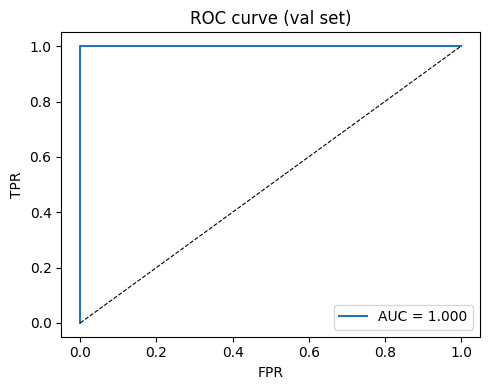

In [ ]:
# Evaluate model_best_realonly.pt on val set, show confusion matrix, classification report, ROC/AUC
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from pathlib import Path
from torch_geometric.data import DataLoader

OUT_DIR = Path('/content/drive/MyDrive/oasis_project/outputs')
best_path = OUT_DIR / "model_best_realonly.pt"
assert best_path.exists(), f"Best model not found at {best_path}"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild model architecture used in training
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn

class TinySAGEReg(nn.Module):
    def __init__(self, in_ch, hid=64, outc=2, p_drop=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid)
        self.conv2 = SAGEConv(hid, hid)
        self.lin = nn.Linear(hid, outc)
        self.drop = nn.Dropout(p_drop)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.drop(x)
        return self.lin(x)

# load mapping to rebuild val indices (subject-level split)
map_csv = Path('/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping_annotated.csv')
df_map = None
if map_csv.exists():
    import pandas as pd
    df_map = pd.read_csv(map_csv)
else:
    raise FileNotFoundError("Annotated mapping CSV not found. Run mapping step first.")

# selected_idx used in your training (real-only)
selected_idx = df_map[~df_map['is_pseudo']].index.tolist()
# create subj2idx and subject-level split same as training
from collections import defaultdict
subj2idx = defaultdict(list)
for i in selected_idx:
    sid = df_map.loc[i,'subject_id']
    subj2idx[str(sid)].append(int(i))
subj_list = list(subj2idx.keys())
from sklearn.model_selection import train_test_split
train_subj, val_subj = train_test_split(subj_list, test_size=0.2, random_state=42, shuffle=True)
val_idx   = [idx for s in val_subj   for idx in subj2idx[s]]

val_graphs = [graphs[i] for i in val_idx]
val_loader = DataLoader(val_graphs, batch_size=8, shuffle=False)

# load model
in_ch = graphs[0].x.shape[1]
model = TinySAGEReg(in_ch, hid=64, outc=2, p_drop=0.3).to(device)
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# predict
y_true_list, y_pred_list, y_prob_list = [], [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()  # probability of class 1
        preds = out.argmax(dim=1).cpu().numpy()
        try:
            labs = batch.y.view(-1).cpu().numpy()
            labs[labs<0] = 0
        except Exception:
            labs = np.zeros_like(preds)
        y_true_list.append(labs); y_pred_list.append(preds); y_prob_list.append(probs)

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
y_prob = np.concatenate(y_prob_list)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

# ROC/AUC if binary
if len(np.unique(y_true))==2:
    try:
        auc = roc_auc_score(y_true, y_prob)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        print(f"ROC AUC: {auc:.4f}")
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
        plt.plot([0,1],[0,1],'k--', linewidth=0.8)
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curve (val set)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("ROC computation failed:", e)


In [ ]:
import numpy as np
labels = [int(graphs[i].y.item()) for i in range(len(graphs)) if graphs[i].y.item()>=0]
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(160), np.int64(1): np.int64(49)}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, torch

classes = np.array([0,1])
weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Class weights:", class_weights)


Class weights: tensor([0.6531, 2.1327], device='cuda:0')


Subjects: total 209 train 167 val 42
Graphs: train 167 val 42
Class weights used: tensor([0.6523, 2.1410], device='cuda:0')


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/20 — train_loss: 0.6879 val_loss: 0.6895
  -> saved best model
Epoch 2/20 — train_loss: 0.6837 val_loss: 0.6884
  -> saved best model
Epoch 3/20 — train_loss: 0.6814 val_loss: 0.6789
  -> saved best model
Epoch 4/20 — train_loss: 0.6749 val_loss: 0.6652
  -> saved best model
Epoch 5/20 — train_loss: 0.6539 val_loss: 0.6465
  -> saved best model
Epoch 6/20 — train_loss: 0.6289 val_loss: 0.6116
  -> saved best model
Epoch 7/20 — train_loss: 0.5998 val_loss: 0.5623
  -> saved best model
Epoch 8/20 — train_loss: 0.5266 val_loss: 0.4940
  -> saved best model
Epoch 9/20 — train_loss: 0.4683 val_loss: 0.4147
  -> saved best model
Epoch 10/20 — train_loss: 0.3621 val_loss: 0.3194
  -> saved best model
Epoch 11/20 — train_loss: 0.2838 val_loss: 0.2388
  -> saved best model
Epoch 12/20 — train_loss: 0.2152 val_loss: 0.1683
  -> saved best model
Epoch 13/20 — train_loss: 0.1522 val_loss: 0.1191
  -> saved best model
Epoch 14/20 — train_loss: 0.1109 val_loss: 0.0884
  -> saved best model
E

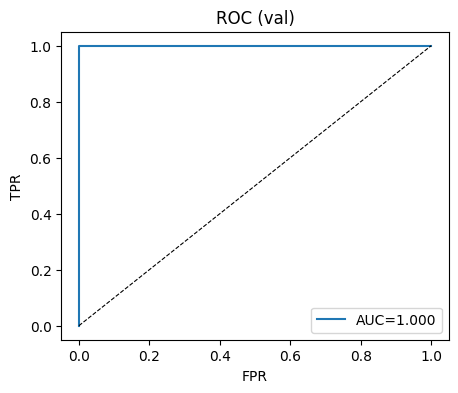

Done. Artifacts saved to: /content/drive/MyDrive/oasis_project/outputs


In [ ]:
# === Retrain with class-weighted loss + subject-level stratified split ===
import numpy as np, torch, os, pandas as pd
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# Config
OUT_DIR = Path('/content/drive/MyDrive/oasis_project/outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
BATCH = 8
LR = 1e-3
WEIGHT_DECAY = 1e-4
P_DROP = 0.3

# Load annotated mapping (should already exist)
map_csv = Path('/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping_annotated.csv')
assert map_csv.exists(), "Annotated mapping CSV missing."

df_map = pd.read_csv(map_csv)
# Ensure y column is integer
df_map['y'] = df_map['y'].astype(int)

# Build subject -> graph idx mapping for selected graphs (use only those with y>=0)
valid_idx = df_map.index[df_map['y'] >= 0].tolist()
subj2idx = defaultdict(list)
for i in valid_idx:
    sid = str(df_map.loc[i, 'subject_id'])
    subj2idx[sid].append(int(i))

# Compute subject-level label (majority label across the subject's graphs)
subj_labels = {}
for sid, idxs in subj2idx.items():
    labs = [int(df_map.loc[i,'y']) for i in idxs]
    subj_labels[sid] = int(np.bincount(labs).argmax())

# Prepare subject list and stratify split by subject label
subjects = list(subj_labels.keys())
subject_labels_arr = np.array([subj_labels[s] for s in subjects])
train_subj, val_subj = train_test_split(subjects, test_size=0.2, random_state=42, stratify=subject_labels_arr)

train_idx = [i for s in train_subj for i in subj2idx[s]]
val_idx   = [i for s in val_subj   for i in subj2idx[s]]
print("Subjects: total", len(subjects), "train", len(train_subj), "val", len(val_subj))
print("Graphs: train", len(train_idx), "val", len(val_idx))

# Attach labels into graphs (ensure datatype)
for i in df_map.index:
    graphs[i].y = torch.tensor([int(df_map.loc[i,'y'])], dtype=torch.long)

# Compute class weights (balanced) from the labels in training set
train_labels = np.array([int(graphs[i].y.item()) for i in train_idx])
classes = np.unique(train_labels)
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=classes, y=train_labels)
# map back to full set of classes (ensure index 0..C-1)
max_cls = int(train_labels.max())
full_weights = np.ones(max_cls+1, dtype=float)
for c, w in zip(classes, weights):
    full_weights[int(c)] = float(w)
class_weights = torch.tensor(full_weights, dtype=torch.float).to(device)
print("Class weights used:", class_weights)

# DataLoaders
train_loader = DataLoader([graphs[i] for i in train_idx], batch_size=BATCH, shuffle=True)
val_loader   = DataLoader([graphs[i] for i in val_idx],   batch_size=BATCH, shuffle=False)

# Model
class TinySAGEReg(nn.Module):
    def __init__(self, in_ch, hid=64, outc=2, p_drop=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid)
        self.conv2 = SAGEConv(hid, hid)
        self.lin = nn.Linear(hid, outc)
        self.drop = nn.Dropout(p_drop)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = self.drop(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.drop(x)
        return self.lin(x)

in_ch = graphs[0].x.shape[1]
n_classes = max(2, int(df_map['y'].max()+1))
model = TinySAGEReg(in_ch, hid=64, outc=n_classes, p_drop=P_DROP).to(device)

opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Training with best-val checkpointing
best_val_loss = float('inf')
for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for batch in train_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        y = batch.y.view(-1).to(device)
        # guard (should not be -1 in selected sets)
        y[y < 0] = 0
        loss = loss_fn(out, y)
        opt.zero_grad(); loss.backward(); opt.step()
        train_losses.append(float(loss.detach().cpu().numpy()))
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            y = batch.y.view(-1).to(device)
            y[y < 0] = 0
            loss = loss_fn(out, y)
            val_losses.append(float(loss.detach().cpu().numpy()))
    avg_train = np.mean(train_losses) if train_losses else float('nan')
    avg_val = np.mean(val_losses) if val_losses else float('nan')
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {avg_train:.4f} val_loss: {avg_val:.4f}")
    # checkpoint best
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), OUT_DIR / "model_best_weighted.pt")
        print("  -> saved best model")

# Load best model and evaluate
model.load_state_dict(torch.load(OUT_DIR / "model_best_weighted.pt", map_location=device))
model.to(device).eval()

y_true_list, y_pred_list, y_prob_list = [], [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy() if n_classes>1 else np.zeros(out.shape[0])
        preds = out.argmax(dim=1).cpu().numpy()
        labs = batch.y.view(-1).cpu().numpy()
        labs[labs < 0] = 0
        y_true_list.append(labs); y_pred_list.append(preds); y_prob_list.append(probs)

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
y_prob = np.concatenate(y_prob_list)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
if len(np.unique(y_true))==2:
    try:
        auc = roc_auc_score(y_true, y_prob)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        print("ROC AUC:", auc)
        plt.figure(figsize=(5,4))
        plt.plot(fpr,tpr,label=f'AUC={auc:.3f}'); plt.plot([0,1],[0,1],'k--',linewidth=0.8)
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (val)'); plt.legend(); plt.show()
    except Exception as e:
        print("ROC error:", e)

# Save final model and mapping for reproducibility
torch.save(model.state_dict(), OUT_DIR / "model_final_weighted.pt")
df_map.to_csv(OUT_DIR / "graph_label_mapping_annotated_saved.csv", index=False)
print("Done. Artifacts saved to:", OUT_DIR)


In [ ]:
# confirm no subject overlap
from collections import defaultdict
import pandas as pd
map_csv = '/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping_annotated.csv'
df_map = pd.read_csv(map_csv)
# build subj2idx and same split as training
subj2idx = defaultdict(list)
for i in df_map.index:
    sid = df_map.loc[i,'subject_id']
    subj2idx[str(sid)].append(i)

# get subject lists used in weighted training (from your last run)
subjects = list(subj2idx.keys())
from sklearn.model_selection import train_test_split
labels = [int(pd.Series([int(df_map.loc[i,'y']) for i in subj2idx[s]]).mode()[0]) for s in subjects]
train_subj, val_subj = train_test_split(subjects, test_size=0.2, random_state=42, stratify=labels)
overlap = set(train_subj).intersection(set(val_subj))
print("Overlap subjects:", overlap)


Overlap subjects: set()


In [ ]:
# run predictions on val_loader again and show probability stats
import numpy as np, torch
from pathlib import Path
# uses model from scope; if not in scope, load best weighted model file
best = Path('/content/drive/MyDrive/oasis_project/outputs/model_best_weighted.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if 'model' not in globals():
    # rebuild model arch like before then load
    from torch_geometric.nn import SAGEConv, global_mean_pool
    import torch.nn.functional as F, torch.nn as nn
    class TinySAGEReg(nn.Module):
        def __init__(self, in_ch, hid=64, outc=2, p_drop=0.3):
            super().__init__()
            self.conv1 = SAGEConv(in_ch, hid)
            self.conv2 = SAGEConv(hid, hid)
            self.lin = nn.Linear(hid, outc)
            self.drop = nn.Dropout(p_drop)
        def forward(self, x, edge_index, batch):
            x = self.conv1(x, edge_index); x = F.relu(x)
            x = self.drop(x)
            x = self.conv2(x, edge_index)
            x = global_mean_pool(x, batch)
            x = self.drop(x)
            return self.lin(x)
    in_ch = graphs[0].x.shape[1]
    model = TinySAGEReg(in_ch, hid=64, outc=2, p_drop=0.3).to(device)
    model.load_state_dict(torch.load(best, map_location=device))
    model.eval()

# build val_loader same as last run (subject-level split)
# (re-create train_subj/val_subj exactly like training cell did)
from collections import defaultdict
subj2idx = defaultdict(list)
for i in df_map.index:
    sid = df_map.loc[i,'subject_id']
    subj2idx[str(sid)].append(i)
subjects = list(subj2idx.keys())
labels = [int(pd.Series([int(df_map.loc[i,'y']) for i in subj2idx[s]]).mode()[0]) for s in subjects]
from sklearn.model_selection import train_test_split
train_subj, val_subj = train_test_split(subjects, test_size=0.2, random_state=42, stratify=labels)
val_idx = [idx for s in val_subj for idx in subj2idx[s]]
from torch_geometric.data import DataLoader
val_loader = DataLoader([graphs[i] for i in val_idx], batch_size=8, shuffle=False)

probs = []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        p = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        probs.append(p)
probs = np.concatenate(probs)
print("Prob stats: min", probs.min(), "max", probs.max(), "mean", probs.mean(), "median", np.median(probs))


Prob stats: min 0.0052674464 max 0.9980221 mean 0.2502489 median 0.026091063


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# 5-fold subject-level CV (stratified on subject label)
import numpy as np, torch, pandas as pd
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch.nn.functional as F, torch.nn as nn

df_map = pd.read_csv('/content/drive/MyDrive/oasis_project/outputs/graph_label_mapping_annotated.csv')
# only use entries with y>=0
df_map = df_map[df_map['y']>=0].reset_index(drop=True)

# map subject -> indices and subject labels
subj2idx = defaultdict(list)
for i,r in df_map.iterrows():
    subj2idx[str(r.subject_id)].append(int(r.name))  # careful: use new df_map index
# simpler: rebuild subj_list and subj_label arrays
# we'll collect one index per subject for label
subjects = list({str(r.subject_id) for _,r in df_map.iterrows()})
subj_labels = []
subj_indices = []
for s in subjects:
    idxs = df_map.index[df_map['subject_id']==s].tolist()
    labs = df_map.loc[idxs,'y'].values
    subj_labels.append(int(np.bincount(labs).argmax()))
    subj_indices.append(idxs)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for fold,(train_idx, val_idx) in enumerate(skf.split(subjects, subj_labels),1):
    # build graph idx lists for fold
    train_graph_idx = [i for j in train_idx for i in subj_indices[j]]
    val_graph_idx = [i for j in val_idx for i in subj_indices[j]]
    train_loader = DataLoader([graphs[i] for i in train_graph_idx], batch_size=8, shuffle=True)
    val_loader = DataLoader([graphs[i] for i in val_graph_idx], batch_size=8, shuffle=False)

    # model init
    class Tiny(nn.Module):
        def __init__(self, in_ch, hid=64, outc=2):
            super().__init__()
            self.conv1 = SAGEConv(in_ch, hid)
            self.conv2 = SAGEConv(hid, hid)
            self.lin = nn.Linear(hid, outc)
        def forward(self,x,edge_index,batch):
            x = self.conv1(x, edge_index); x = F.relu(x)
            x = self.conv2(x, edge_index)
            x = global_mean_pool(x, batch)
            return self.lin(x)
    in_ch = graphs[0].x.shape[1]
    model = Tiny(in_ch).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # compute class weights from train labels
    import numpy as np
    train_labels = np.array([int(graphs[i].y.item()) for i in train_graph_idx])
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(train_labels)
    weights = compute_class_weight('balanced', classes=classes, y=train_labels)
    full_weights = np.ones(int(train_labels.max())+1, dtype=float)
    for c,w in zip(classes,weights): full_weights[int(c)]=w
    loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(full_weights,dtype=torch.float).to(device))

    # short train (few epochs)
    for epoch in range(6):
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            y = batch.y.view(-1).to(device)
            y[y<0]=0
            loss = loss_fn(out,y)
            opt.zero_grad(); loss.backward(); opt.step()
    # eval
    model.eval()
    y_true,y_pred,y_prob = [],[],[]
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            p = torch.softmax(out,dim=1)[:,1].cpu().numpy() if out.shape[1]>1 else np.zeros(out.shape[0])
            preds = out.argmax(dim=1).cpu().numpy()
            labs = batch.y.view(-1).cpu().numpy(); labs[labs<0]=0
            y_true.append(labs); y_pred.append(preds); y_prob.append(p)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred); y_prob = np.concatenate(y_prob)
    acc = accuracy_score(y_true,y_pred)
    rec = recall_score(y_true,y_pred, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(y_true,y_prob)
    except:
        auc = float('nan')
    fold_metrics.append({'fold':fold,'acc':acc,'recall':rec,'auc':auc})
    print(f"Fold {fold}: acc={acc:.3f} recall={rec:.3f} auc={auc:.3f}")

import pandas as pd
print("CV summary:\n", pd.DataFrame(fold_metrics).describe())


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: acc=0.952 recall=0.800 auc=1.000


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 2: acc=1.000 recall=1.000 auc=1.000


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 3: acc=0.857 recall=0.400 auc=1.000


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 4: acc=0.786 recall=0.100 auc=1.000


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 5: acc=0.805 recall=0.111 auc=1.000
CV summary:
            fold       acc    recall  auc
count  5.000000  5.000000  5.000000  5.0
mean   3.000000  0.880023  0.482222  1.0
std    1.581139  0.093132  0.406096  0.0
min    1.000000  0.785714  0.100000  1.0
25%    2.000000  0.804878  0.111111  1.0
50%    3.000000  0.857143  0.400000  1.0
75%    4.000000  0.952381  0.800000  1.0
max    5.000000  1.000000  1.000000  1.0


In [ ]:
from pathlib import Path
roots = [Path('/content/drive/MyDrive/oasis_project/data/preprocessed'),
         Path('/MyDrive/oasis_project/data/preprocessed')]
for r in roots:
    print("-", r, "exists?", r.exists())
    if r.exists():
        print("  subdirs:", [p.name for p in r.iterdir()][:20])
man = Path('/content/drive/MyDrive/oasis_project/data/preprocessed/preproc_manifest.csv')
print("preproc_manifest.csv exists at Drive path?", man.exists())
# quick search for any _preproc.nii.gz files
cands = list(Path('/content/drive/MyDrive').rglob('*_preproc.nii.gz')) + list(Path('/MyDrive').rglob('*_preproc.nii.gz'))
print("Found preproc NIfTI count:", len(cands))
for p in cands[:10]:
    print("  ", p)


- /content/drive/MyDrive/oasis_project/data/preprocessed exists? False
- /MyDrive/oasis_project/data/preprocessed exists? False
preproc_manifest.csv exists at Drive path? False
Found preproc NIfTI count: 0
